<a href="https://colab.research.google.com/github/AnhDao1411/CSC14115/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York City Taxi Trip Duration

## Problem Statement

### Overview
This is a kaggle competition that challenges us to predict the taxi trip duration in New York city. Dataset is provided by the NYC taxi and Limousine commision for building a model.

Money prize: 30,000$.

Business motivation: providing good driving time estimation to
- Detect bottlenecks that appear in the taxi traffic network.
- Predict the taxi trip price. 

Input: a taxi trip with it's attributes. \
Output: trip duration in seconds. 
 
### Input and Output Data description

There are three files:
- train.csv: (1458644,11)
- test.csv: (625134,9)
- sample_submission.csv: (625134,2) 

| Column name | Description | 
| -------- | -------- | 
| id   | the id for each trip     |
| vendor_id   | the id provided Associated with the trip record     |
| pickup_datetime   | date and time when the meter was engaged     |
| dropoff_datetime   | date and time when the meter was disengaged    |
| passenger_count   | The number of passengers in the taxi    |
| pickup_longitude   | the longitude when the meter was engaged     |
| pickup_latitude   | the latitude when the meter was engaged   |
| dropoff_longitude   | the longitude when the meter was disengaged     |
| dropoff_latitude   | the latitude when the meter was disengaged     |
| store_and_fwd_flag   | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  |
| trip_duration  | duration of the trip in seconds     |


- A record in train.csv

![](https://i.imgur.com/LtLFbTO.png)

- A record in test.csv
![](https://i.imgur.com/gEJR1jT.png)

- A record in sample_submission.csv
![](https://i.imgur.com/zwq0ezw.png)




### Evaluation Metric
- **Root Mean Squared Logarithmic Error** (RMSLE) is the metric was used to assess the result of this contest.

$$\epsilon = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(log(p_i + 1) -log(a_i + 1)) ^2}$$

* With respect to:
    * $\epsilon$: RMSLE score
    * n: the number of records (trip duration's observations) in the dataset
    * $p_i$: the prediction of trip duration
    * $a_i$: the actual value of trip duration
    * log(x): natural logarithm (base is e)

* **The smaller the RMSLE value is, the better the model**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# !unzip ../input/nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration
# !unzip ../input/nyc-taxi-trip-duration/test.zip -d nyc-taxi-trip-duration
# !unzip ../input/nyc-taxi-trip-duration/sample_submission.zip -d nyc-taxi-trip-duration
%cd /content/drive/MyDrive/CSC14115 - KHDLUD

/content/drive/.shortcut-targets-by-id/1X9WZOvukNSK-VHf1Vue6YDbHXMF8g2rc/CSC14115 - KHDLUD


## Explore data and Extract features

In [ ]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('./nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('./nyc-taxi-trip-duration/sample_submission.csv')

In [ ]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663


In [ ]:
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.99,40.73,-73.99,40.76,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.96,40.68,-73.96,40.66,N


### Basic information of datasets (train and test)

* Check whether the dataset has :
    * unique values for the id column.
    * missing values.
    * duplicate record.
    * the trip_duration values are consistent with pickup and dropoff datetime (only for the training dataset).

In [ ]:
def check_basic(df, df_type="train"):
    print("{} DF has {} rows and {} columns".format(df_type,df.shape[0], df.shape[1]))
    if df.id.nunique() == df.shape[0]:
        print("1. Id is unique")
    if not df.isnull().any().any(): 
        print("2. No missing value")
    if train.duplicated(keep='first').sum() == 0:
        print("3. No duplicate record")
    if df_type == 'train':
        trip_duration_diff = (pd.to_datetime(train.dropoff_datetime) - pd.to_datetime(train.pickup_datetime)).map(lambda x :x.total_seconds())
        if len(df[np.abs(trip_duration_diff.values - df['trip_duration'].values) > 1]) == 0:
            print("4. Trip_duration is consistent with pickup and dropoff times.")

In [ ]:
check_basic(train, df_type="train")

train DF has 1458644 rows and 11 columns
1. Id is unique
2. No missing value
3. No duplicate record
4. Trip_duration is consistent with pickup and dropoff times.


In [ ]:
check_basic(test, df_type="test")

test DF has 625134 rows and 9 columns
1. Id is unique
2. No missing value
3. No duplicate record


* Show the datatype of each column in dataset.

In [ ]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

Train:
 id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object 

Test:
 id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object


* Show the number of unique values in each column.

In [ ]:
train.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

#### Convert datatypes

* Because datatypes of `pickup_datetime` and `dropoff_datetime` are "**object**" which is difficult when we handle it with built-in functions of pandas $\rightarrow$ we convert it into "**datetime**" datatype to be easy to extract data from these columns.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

* We convert the datatype of the vendor_id column from **int64** to **object** (str) because:
    * vendor_id is the id provided Associated with the trip record.
    * this column only has 2 unique values, 1 and 2, but it does not mean 2 is bigger than 1.

In [ ]:
train['vendor_id'] = train['vendor_id'].astype(str)
test['vendor_id'] = test['vendor_id'].astype(str)

#### Statistics information of the train set

In [ ]:
train.describe(datetime_is_numeric = True)

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644,1458644,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528,1.66,-73.97,40.75,-73.97,40.75,959.49
min,2016-01-01 00:00:17,2016-01-01 00:03:31,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2016-04-01 17:19:40,2016-04-01 17:35:12,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2016-06-30 23:59:39,2016-07-01 23:02:03,9.00,-61.34,51.88,-61.34,43.92,3526282.00
std,NaN,NaN,1.31,0.07,0.03,0.07,0.04,5237.43


* Get numeric, categorical column names

In [ ]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)
print("Num cols: ",num_cols)
print("Cate cols: ",cate_cols)

Num cols:  ['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
Cate cols:  ['id', 'vendor_id', 'store_and_fwd_flag']


##### Numeric columns

In [ ]:
def value_percentages(col):
    val = col.groupby(by=col).count().sort_values(ascending=False)
    total = val.sum()
    return (((val / total)*100).round(1)).to_dict()

def num_values(col):
    return col.nunique()

In [ ]:
train[num_cols].agg([value_percentages, num_values])

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
value_percentages,"{2016-03-04 08:07:34: 0.0, 2016-01-12 18:48:44...","{2016-02-19 19:25:04: 0.0, 2016-05-16 19:40:28...","{1: 70.9, 2: 14.4, 5: 5.4, 3: 4.1, 6: 3.3, 4: ...","{-73.9822006225586: 0.0, -73.98213958740233: 0...","{40.77410125732422: 0.0, 40.774089813232415: 0...","{-73.98233032226561: 0.0, -73.98209381103516: ...","{40.774311065673835: 0.0, 40.77433013916016: 0...","{368: 0.1, 408: 0.1, 348: 0.1, 367: 0.1, 358: ..."
num_values,1380222,1380377,10,23047,45245,33821,62519,7417


* **Observation**:

$→$ The number of distinct values of `pickup_datetime` and `dropoff_datetime` takes up more than **90%** of the dataset $→$ extract the data of these columns to new columns (month, hour, day,...) to reduce the unique.

$→$ The value of longitude and latitude have **float64** datatypes $→$ it is difficult to compare.

##### Categorical columns

In [ ]:
train[cate_cols].agg([value_percentages, num_values])

,id,vendor_id,store_and_fwd_flag
value_percentages,"{'id0000001': 0.0, 'id2665099': 0.0, 'id266515...","{'2': 53.5, '1': 46.5}","{'N': 99.4, 'Y': 0.6}"
num_values,1458644,2,2


In [ ]:
train.groupby('store_and_fwd_flag')['trip_duration'].agg(['mean', 'min', 'max'])

,mean,min,max
store_and_fwd_flag,,,
N,958.82,1,3526282
Y,1080.76,2,9984


* **Observation**:

$→$ The `store_and_fwd_flag` column has only 2 values, N và Y. We decide to remove this column because:

1. The proportions of "N" and "Y" are 99.4% and 0.6%, respectively $→$ "N" dominant this column's value.
2. This column meaning is the flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server $→$ **does not affect** the `trip_duration`.
3. The average trip duration of these two groups has not much different.

### Extract new features

#### From `pickup_datetime`

In [ ]:
train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'day_of_month'] = train['pickup_datetime'].dt.day
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek

test.loc[:, 'pick_month'] = test['pickup_datetime'].dt.month
test.loc[:, 'hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'day_of_month'] = test['pickup_datetime'].dt.day
test.loc[:, 'day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [ ]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_month,hour,day_of_month,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,3,17,14,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,6,0,12,6


* **Comment**:

$→$ Because this problem predicts the trip_duration so that the `dropoff_datetime` column is not necessary $→$ we **remove** this column.

In [ ]:
train.drop(['pickup_datetime', 'dropoff_datetime'], axis =1, inplace= True)
test.drop(['pickup_datetime'], axis =1, inplace= True)

#### Remove `store_and_fwd_flag`

In [ ]:
train.drop('store_and_fwd_flag', axis = 1, inplace=True)
test.drop('store_and_fwd_flag', axis = 1, inplace=True)

In [ ]:
train.head(1)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_month,hour,day_of_month,day_of_week
0,id2875421,2,1,-73.98,40.77,-73.96,40.77,455,3,17,14,0


#### Distance 

* The solution of Beluga about haversine distance and manhattan distance (in km).


In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [ ]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                                     test['pickup_longitude'].values,
                                                     test['dropoff_latitude'].values,
                                                     test['dropoff_longitude'].values)

In [ ]:
train.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values,
                                                              train['pickup_longitude'].values,
                                                              train['dropoff_latitude'].values,
                                                              train['dropoff_longitude'].values)

test.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                              test['pickup_longitude'].values,
                                                              test['dropoff_latitude'].values,
                                                              test['dropoff_longitude'].values)

In [ ]:
train[["id","distance_haversine","distance_manhattan"]].head(2)

,id,distance_haversine,distance_manhattan
0,id2875421,1.50,1.74
1,id2377394,1.81,2.43


* Determine the direction of pickup and dropoff positions and divide it into 8 bins (N, NE, E, SE, S, SW, W, NW):
    * Bearing_array function from solution of Beluga.
    * Assign direction for each degree.



In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, 
                                          train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, 
                                          train['dropoff_longitude'].values)

test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, 
                                          test['pickup_longitude'].values, 
                                          test['dropoff_latitude'].values, 
                                          test['dropoff_longitude'].values)

In [ ]:
train[["id","direction"]].describe()

,direction
count,1458644.00
mean,-15.67
std,104.49
min,-179.99
25%,-125.27
50%,8.20
75%,53.40
max,180.00


In [ ]:
new_df = train.copy()
train.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
train.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
train.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
train.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
train.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
train.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
train.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
train.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"


new_df = test.copy()
test.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
test.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
test.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
test.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
test.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
test.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
test.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
test.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"

In [ ]:
train["direction"].unique()

array(['N', 'SW', 'W', 'SE', 'NE', 'NW', 'E', 'S'], dtype=object)

#### Speed features (from Beluga's notebook)

In [ ]:
train.loc[:, "avg_speed_h"] = 1000 * train["distance_haversine"] / train["trip_duration"]
train.loc[:, "avg_speed_m"] = 1000 * train["distance_manhattan"] / train["trip_duration"]

* Based on the tuple of longitude and latitude, we using KMeans in order to cluster pickup and dropoff positions to 100 groups respectively. Learning Kmeans with 500000 examples from both train and test set.
* From the area clustered, the average speed features can be extracted based on pickup, dropoff groups, and pickup hour. These features can be used in test set.

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

* New features of speed (use average speed of haversine distance) groups by: `hour` - `pickup_cluster`, `hour` - `dropoff_cluster`, `pickup_cluster` - `dropoff_cluster`.
* To avoid learning model being overfitted, we only keep the shared values of each group with a count over 100.
* Average speed of haversine distance is calculated on the train set so that the test set does not leak.

In [ ]:
for gby_cols in [['hour', 'pickup_cluster'],  ['hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

#### Round value of longitude and latitude

* We round the decimal part of longitude and latitude to 3 numbers because the definition of third decimal: **"The third decimal place is worth up to 110 m: it can identify a large agricultural field or institutional campus."**

[Meaning of each decimal number position in latitude and longitude](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude?fbclid=IwAR2IC_iFie8AtwfmZHfHCotaMS3fMaKJ14hNb0yN45Z9g0Z5nTOS9aQcBWE)


In [ ]:
train[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']] = train[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']].round(3)

test[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']] = test[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']].round(3)

In [ ]:
num_cols = list(train.select_dtypes(exclude='object').columns)

In [ ]:
train[num_cols].agg([value_percentages, num_values])

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_month,hour,day_of_month,day_of_week,...,avg_speed_h,avg_speed_m,pickup_cluster,dropoff_cluster,avg_speed_h_hour_pickup_cluster,cnt_hour_pickup_cluster,avg_speed_h_hour_dropoff_cluster,cnt_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
value_percentages,"{1: 70.9, 2: 14.4, 5: 5.4, 3: 4.1, 6: 3.3, 4: ...","{-73.982: 3.4, -73.991: 2.7, -73.989: 2.5, -73...","{40.75: 2.5, 40.774: 2.4, 40.751: 2.3, 40.756:...","{-73.982: 2.7, -73.991: 2.5, -73.979: 2.4, -73...","{40.75: 2.3, 40.756: 2.1, 40.764: 1.9, 40.761:...","{368: 0.1, 408: 0.1, 348: 0.1, 367: 0.1, 358: ...","{3: 17.6, 4: 17.3, 5: 17.0, 2: 16.3, 6: 16.1, ...","{18: 6.2, 19: 6.2, 21: 5.8, 20: 5.8, 22: 5.5, ...","{16: 3.5, 14: 3.5, 5: 3.4, 12: 3.4, 15: 3.4, 4...","{4: 15.3, 5: 15.1, 3: 15.0, 2: 14.4, 1: 13.9, ...",...,"{0.0: 0.4, 0.1413916609577237: 0.0, 0.14139166...","{0.0: 0.4, 0.1413916609577237: 0.0, 0.04713055...","{17: 3.8, 49: 3.0, 62: 2.5, 97: 2.2, 28: 2.2, ...","{17: 3.3, 49: 2.5, 62: 2.4, 35: 2.1, 99: 2.1, ...","{3.3046899950634554: 0.2, 3.0881054110196064: ...","{1398.0: 0.4, 1062.0: 0.4, 1758.0: 0.4, 1207.0...","{2.5140050985706472: 0.2, 3.7774136517549253: ...","{912.0: 0.4, 1739.0: 0.4, 996.0: 0.3, 928.0: 0...","{4.521094833341851: 0.2, 3.957474867764764: 0....","{437.0: 0.4, 369.0: 0.3, 430.0: 0.3, 154.0: 0...."
num_values,10,618,498,923,643,7417,6,24,31,7,...,1452587,1452587,100,100,1807,1083,2050,1106,3710,872


* **Observation**:
    * The number of longitudes and latitudes are decrease.
    * The number of unique values in the `distance_haversine` column is nearly the number of rows in dataset.

### Visualize data

#### Histogram all numberic columns

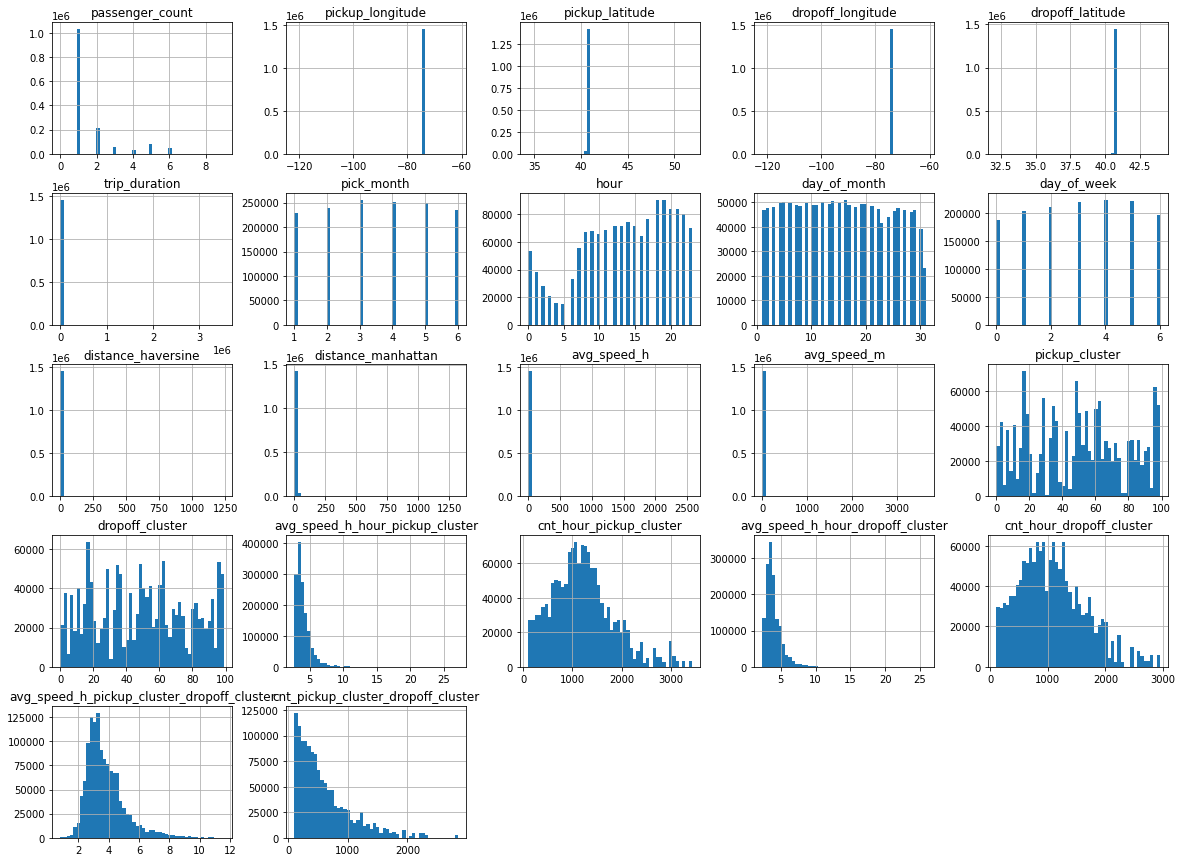

In [ ]:
train[num_cols].hist(figsize=(20, 15), bins = 50)
plt.show()


* Scatter of each numeric column for the number of each value.

In [ ]:
def draw_chart(df, fig_size = (15,15)):
    temp = list(df.columns)
    figure, axis = plt.subplots(len(temp)//2 if len(temp) % 2 == 0 else len(temp)//2 + 1, 2, figsize = fig_size)
    color = ['#582f0e','#936639','#f3722c','#c2c5aa','#414833','#457b9d','#ffb703','#e63946', '#c77dff','#55a630','#f72585','#ffa69e','#4d908e','#7f5539','#b5e48c','#b6ad90','#38b000','#a84c32','#a84c32','#471f13','#8c842d','#408061']
    for i, col in enumerate(temp):
        t = df[col].value_counts()
        axis[i//2, i%2].scatter(list(t.index), t.values, color = color[i])
        axis[i//2, i%2].set_title(col)
    if len(temp) %2 !=0:
        figure.delaxes(axis[len(temp)//2,1])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.show()

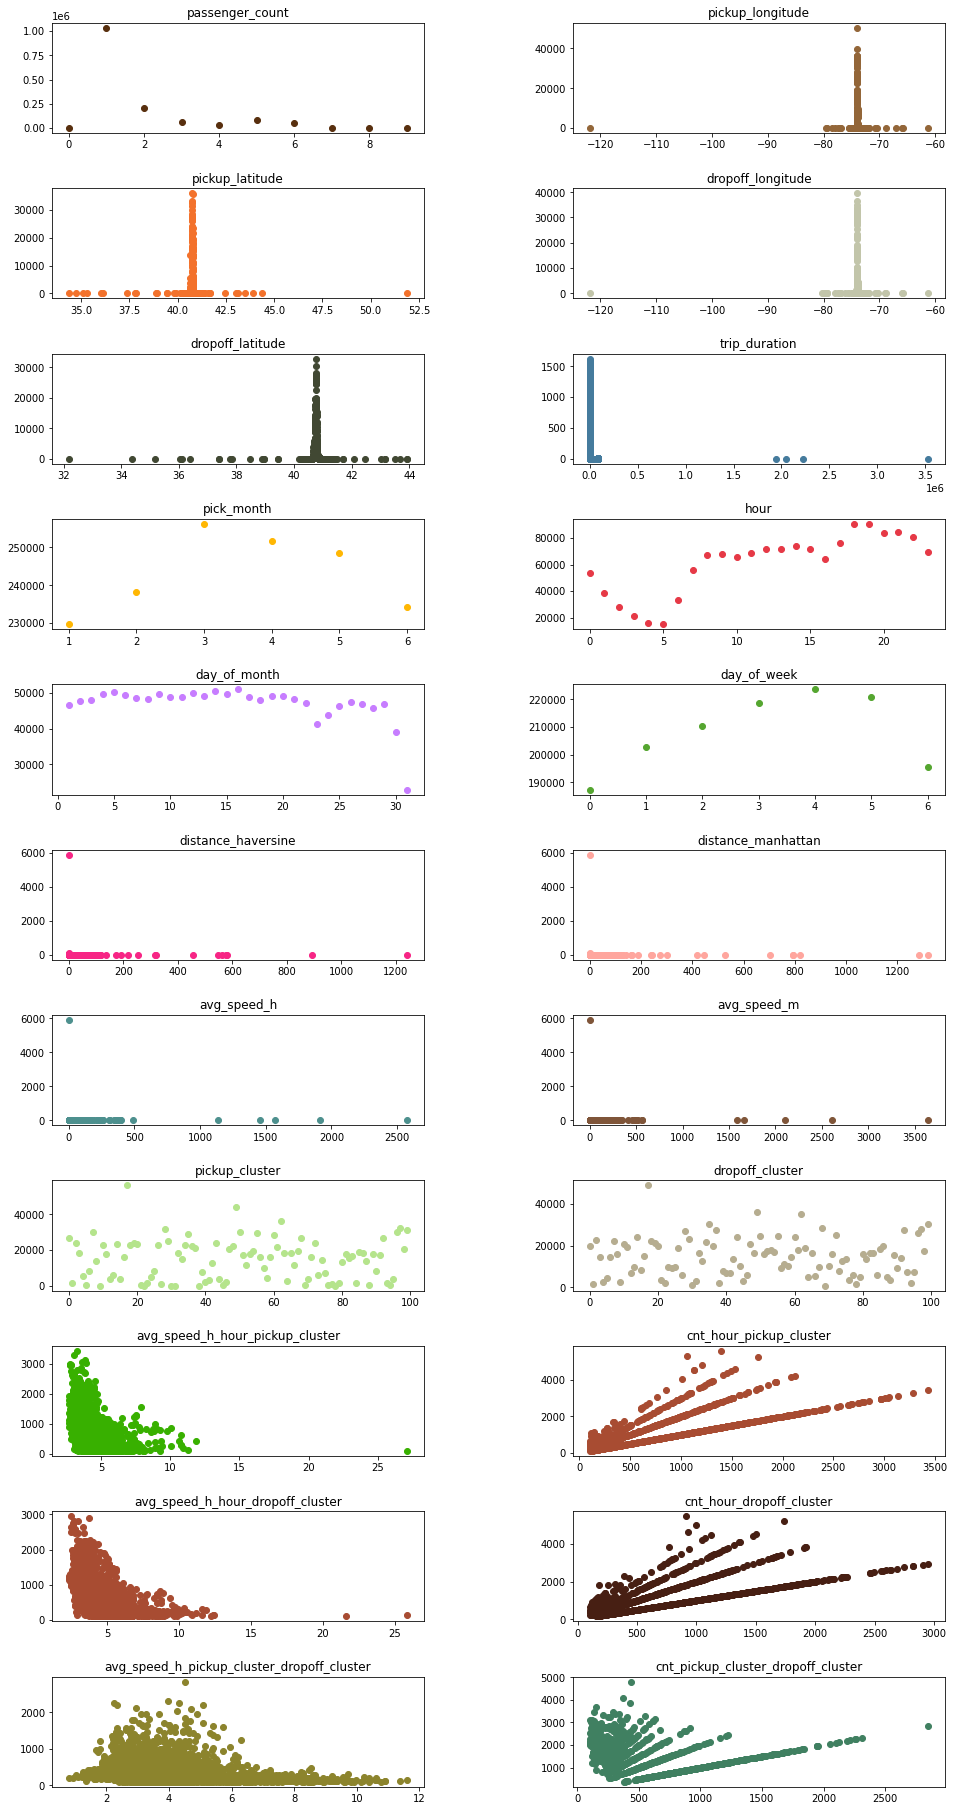

In [ ]:
draw_chart(train[num_cols], (16,25));

 **Comment**:

- pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude have some values which dominate because in this problem we focus on New York city.
- People in New York tends to go alone (passenger = 1)
- pick_month: in March, the number of people using Taxi is the highest.
- hour: less people uses Taxi at 5am and more at 16-20pm.
- day_of_week: on Monday and Sunday, less people uses Taxi
- day_of_month: at the end of a month, the number of human using Taxi decreases.
- 2 types of distance and average speed have no much different.
- Trip duration is calcuated by second so the range is quite big (1e6) and there are some values that occur most of the time.

#### Trip duration column

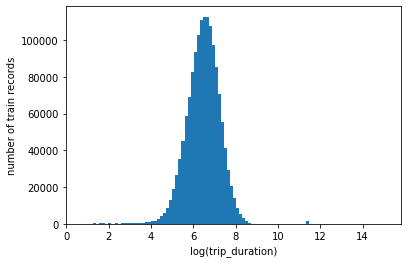

In [ ]:
train_log_trip_duration = np.log(train['trip_duration'].values + 1)
plt.hist(train_log_trip_duration, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

#### Average speed depends on hour and day of week

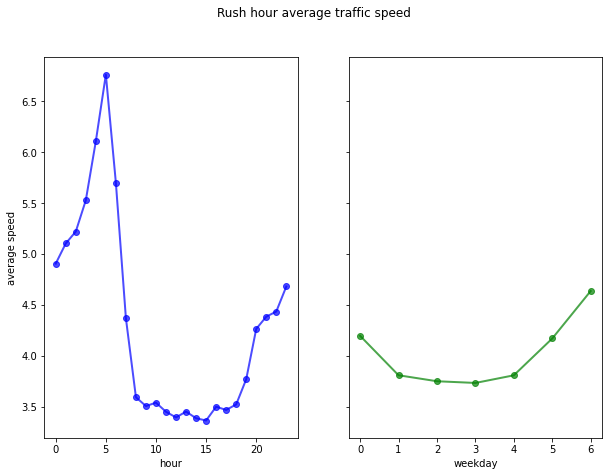

In [ ]:
fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(10, 7))
ax[0].plot(train.groupby('hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('day_of_week').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

**Comment**
- As we can see, because at 5am less people using Taxi so the street won't be crowed $→$ speed will be high. The opposite is true for hours around 16-20pm.
- On Monday and Sunday, the speed is higher than other days.


### Choose columns affect trip duration


In [ ]:
print(len(train.columns)) 
train.columns

25


Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'pick_month', 'hour', 'day_of_month', 'day_of_week',
       'distance_haversine', 'distance_manhattan', 'direction', 'avg_speed_h',
       'avg_speed_m', 'pickup_cluster', 'dropoff_cluster',
       'avg_speed_h_hour_pickup_cluster', 'cnt_hour_pickup_cluster',
       'avg_speed_h_hour_dropoff_cluster', 'cnt_hour_dropoff_cluster',
       'avg_speed_h_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster'],
      dtype='object')

* **The effect of each column on predicting trip_duration**:
    * `id`: id of trip => does not related to trip duration => do not use to predict trip duration.
    
    * `vendor_id`: id of the provider associated with the trip record => does not related to trip duration => do not use to predict trip duration.
    
    * `passenger_count`: the number of passengers does not indicate the speed of that taxi => do not use to predict trip duration.
    
    * `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`: pickup and dropoff position => these attributes can affect the trip duration because it relate to distance features, but they have to many unique values and we also using Kmeans to cluster them => do not use to predict trip duration.
    
    * `trip_duration`: target column.
    
    * Features from pickup_datetime: `pick_month`, `hour`, `day_of_month`, `day_of_week`: this is the basic information of time => Based on those, ***we can know on which time, the number of vehicles will increase***. We do not add minute column because this column is too detail or that can be known by other previous added columns => Feed to model.
    
    * `distance_haversine`, `distance_manhattan`: knowing the distance between two positions can help to estimate the duration => used to predict trip duration.
    
    * `direction`:  the direction of the trip has 8 directions => for each location, which direction do the riders need to move mainly => the traffic situation when moving in the directions at the pick-up point and the pick-up time => affect the prediction of travel time.
    
    * `avg_speed_h`, `avg_speed_m`: do not use these columns to predict the trip duration because they are calculated based on the target column.
    
    * `pickup_cluster`, `dropoff_cluster`: group of nearest/similar pick-up and drop-off latitudes and longitudes ==> We assume that location in that group has the same traffic and has the same impact on trip duration.

    * `avg_speed_h_hour_pickup_cluster`, `avg_speed_h_hour_dropoff_cluster`, `avg_speed_h_pickup_cluster_dropoff_cluster`: because **t = s/v**. Estimate the average speed based on pickup hour, pickup and dropoff clusters. These values are calculated using `avg_speed_h`. Although the `avg_speed_h` is invalid due to using the target column, these values are the average of group by and not directly inferred from them => we can assume these as an estimation for speed => used to predict the trip duration. 

    * `cnt_hour_pickup_cluster`, `cnt_hour_dropoff_cluster`, `cnt_pickup_cluster_dropoff_cluster`: the number of trips in each attribute pair => affects the travel time because it shows how crowded the traffic is at the hour of pick-up, pick-up and drop-off area => used to predict the trip duration.

=> Features rejected: `id`, `vendor_id`, `passenger_count`, `trip_duration`, `avg_speed_h`,  `avg_speed_m`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`.

=> Features used: 
* `pick_month`
* `hour`
* `day_of_month`
* `day_of_week`
* `distance_haversine`
* `distance_manhattan`
* `direction`
* `pickup_cluster`
* `dropoff_cluster`
* `avg_speed_h_hour_pickup_cluster`
* `avg_speed_h_hour_dropoff_cluster`
* `avg_speed_h_pickup_cluster_dropoff_cluster`
* `cnt_hour_pickup_cluster`
* `cnt_hour_dropoff_cluster`
* `cnt_pickup_cluster_dropoff_cluster`

In [ ]:
train = train.drop(columns = ['vendor_id', 'passenger_count', 'avg_speed_h', 'avg_speed_m', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
test = test.drop(columns = ['vendor_id', 'passenger_count', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [ ]:
# Write features_train.csv
# Write features_test.csv

train.to_csv('features_train.csv', index=False)
test.to_csv('features_test.csv', index=False)

## Modeling
Version 1: Nhóm dựa theo các đặc trưng mà solution đưa ra và đã được nhóm tiền xử lý để huấn luyện mô hình. Các đặc trưng nhóm sử dụng sẽ ở mức độ cơ bản.

In [ ]:
# Read features.csv
train = pd.read_csv('features_train.csv')
test = pd.read_csv('features_test.csv')

In [ ]:
do_not_use_for_training = ['id','trip_duration']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [ ]:
print(len(feature_names)) 
feature_names

15


['pick_month',
 'hour',
 'day_of_month',
 'day_of_week',
 'distance_haversine',
 'distance_manhattan',
 'direction',
 'pickup_cluster',
 'dropoff_cluster',
 'avg_speed_h_hour_pickup_cluster',
 'cnt_hour_pickup_cluster',
 'avg_speed_h_hour_dropoff_cluster',
 'cnt_hour_dropoff_cluster',
 'avg_speed_h_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [ ]:
y = np.log(train['trip_duration'].values + 1)

In [ ]:
dtrain = train[feature_names]
dtest = test[feature_names]

### Preprocessor

In [ ]:
# Checking columns that contain null values
dtrain.isnull().sum()

pick_month                                         0
hour                                               0
day_of_month                                       0
day_of_week                                        0
distance_haversine                                 0
distance_manhattan                                 0
direction                                          0
pickup_cluster                                     0
dropoff_cluster                                    0
avg_speed_h_hour_pickup_cluster                20143
cnt_hour_pickup_cluster                        20143
avg_speed_h_hour_dropoff_cluster               21890
cnt_hour_dropoff_cluster                       21890
avg_speed_h_pickup_cluster_dropoff_cluster    167398
cnt_pickup_cluster_dropoff_cluster            167398
dtype: int64

In [ ]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

In [ ]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# import category_encoders as ce
from sklearn.linear_model import LinearRegression

#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)


# scaler = StandardScaler()
# encoder = ce.TargetEncoder(cols=cat_cols)# putting numeric columns to scaler and categorical to encoder
# num_transformer = make_pipeline(imputer, scaler)
# cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])

### Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error

model_linear = LinearRegression()

X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

# giving all values to pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),('linear', model_linear)])
linear_pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = linear_pipe.predict(X_val)

In [ ]:
print(linear_pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('norm',
                                                                   StandardScaler())]),
                                                  ['pick_month', 'hour',
                                                   'day_of_month',
                                                   'day_of_week',
                                                   'distance_haversine',
                                                   'distance_manhattan',
                                                   'pickup_cluster',
                                                 

In [ ]:
# to print the results in good way
print(f"Validation RMSLE: {mean_squared_error(y_pred, y_val, squared=False)}")

Validation RMSLE: 0.6602534006759908


In [ ]:
y_pre_linear = linear_pipe.predict(test)
y_pre_linear = np.exp(y_pre_linear) - 1
y_pre_linear

array([ 801.4100656 ,  540.55395672,  466.23544588, ..., 1248.82179176,
       2815.58781259, 1143.55333669])

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = y_pre_linear
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,801.41
1,id3505355,540.55
2,id1217141,466.24
3,id2150126,885.37
4,id1598245,423.70


In [ ]:
new_df.to_csv("submission_linear.csv", index = False)

* **Week08**

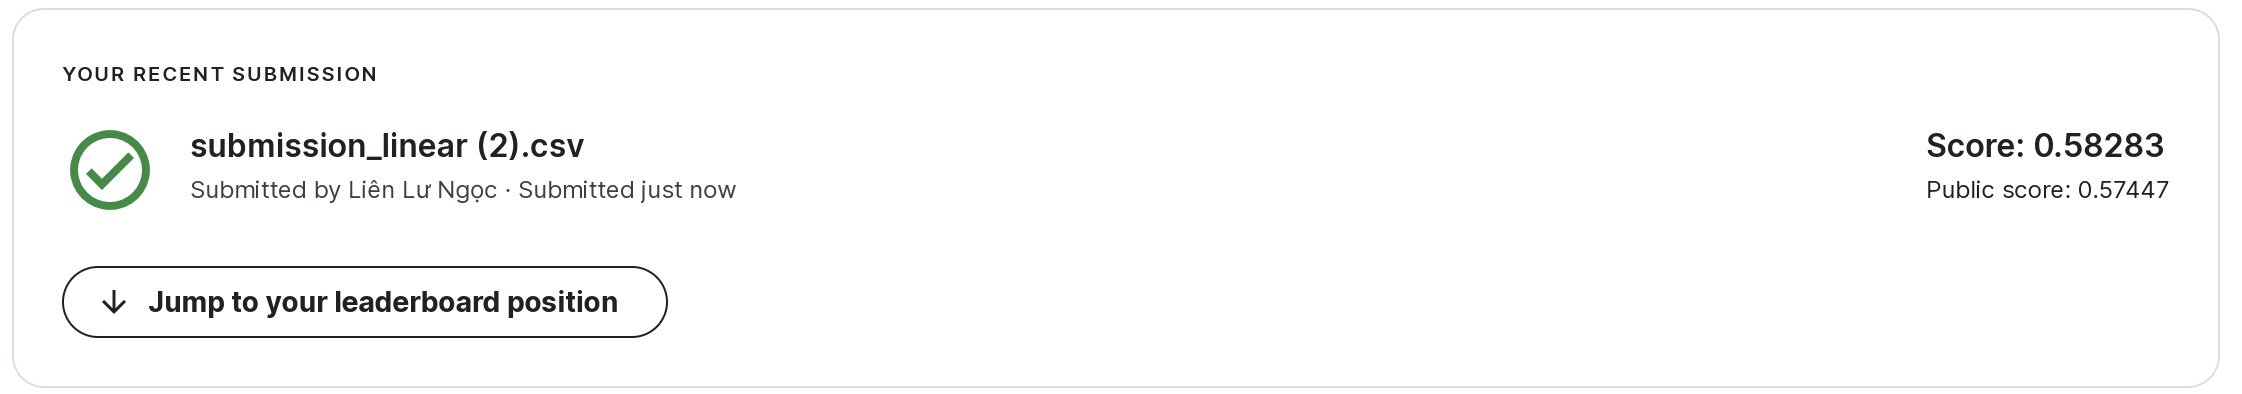

* **Week09**

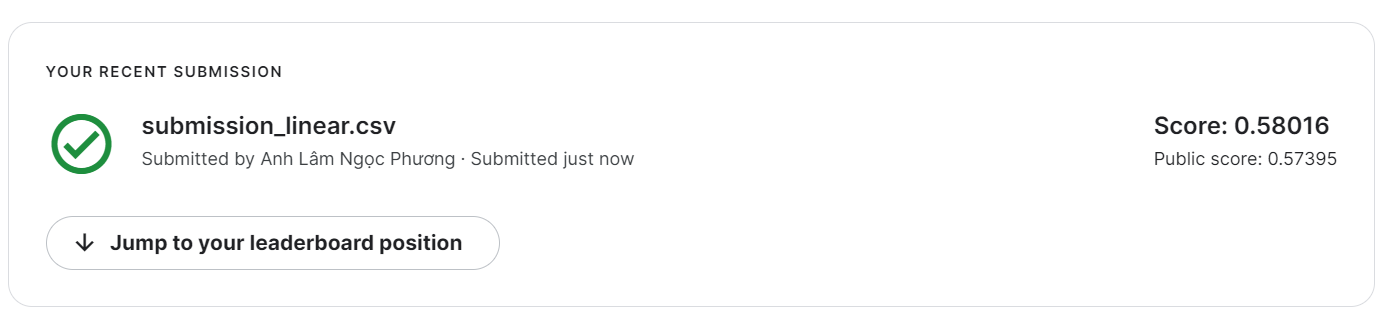

### XGB
**Bagging**

An emsemble meta-estimator:
1.   Fit each base classifier on it's corresponding subsets (random). 
2.   Aggregate their individual prediction. Using voting for classification and calculating mean for regression. 

Random forest is an improvement method upon bagging. Instead of using all features when boostrap sampling, random forest randomly selected features. $\to$ Decision trees more independent and improve the performance. 

Ref: [Geeksforgeeks, @pawangfg, xgboost](https://www.geeksforgeeks.org/xgboost/)

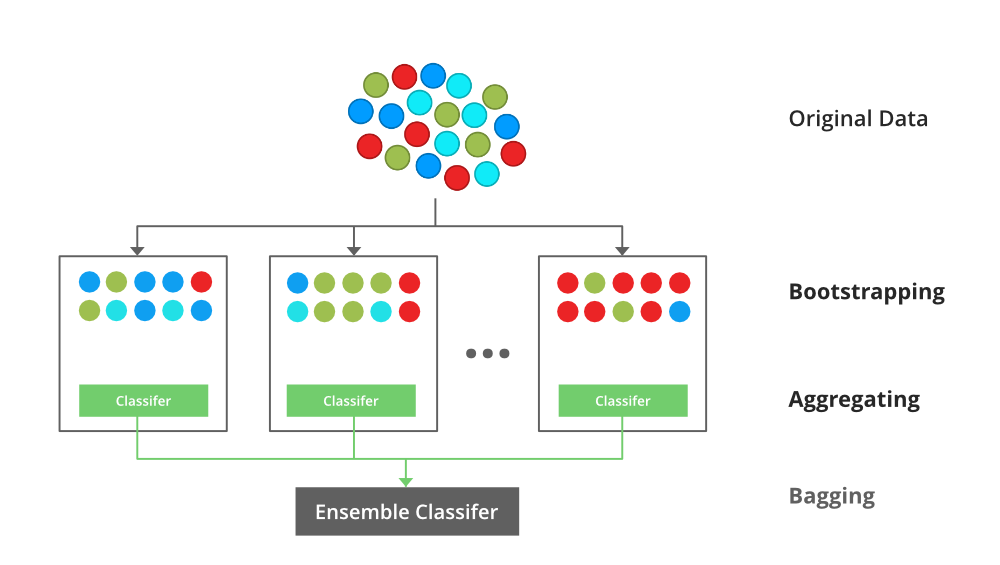

Bagging classifier

image source: [Geeksforgeeks, @pawangfg, xgboost](https://www.geeksforgeeks.org/xgboost/)

**Boosting**

An emsemble method, it temps to build a stronger classifier from a week classifier sequentially. The second model is learned from the errors present in the first model.

XGB (Extreme Gradient Boosting)
Is built from Gradient Boosting technique (The new classifier is trained using the residual erros of previous classifier)
Assign a weight to each variables, the weight of variables which predicted wrong will be increased in the next classifier.


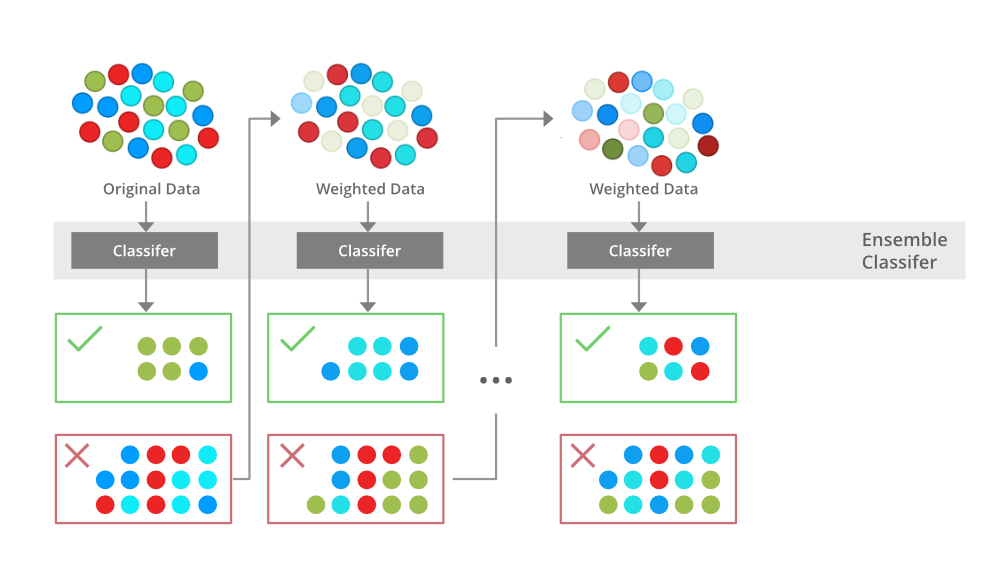

Boosting classifier

image source: [Geeksforgeeks, @pawangfg, xgboost](https://www.geeksforgeeks.org/xgboost/)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

#### Our training

Hyperparameters will focus on 3 categories:





**General parameters**: guide the overall functioning of the XGBoost model

  1. booster: `gbtree` and `dart` - use tree-based models, while `gblinear` uses linear models.

  2. nthread: number of cores for parallel processing

**Booster parameters**
3. eta: is learning rate

4. max_depth: the maximum depth of a tree

4. min_child_weight: minimum sum of weights of all variables

5. subsample: subsample ratio of the training instances

6. colsample_bytree: the subsample ratio of columns when constructing each tree



**Learning task parameters**

Paramaters that using in optimization
8. objective: the loss function 
2. eval_metric: metric for validation data


**Learning task parameters**

In [ ]:
# # Data preprocessing pipeline
# my_pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# # Transform the data
# X_train_xgb = my_pipeline.fit_transform(X_train)
# X_val_xgb = my_pipeline.transform(X_val)


In [ ]:
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['binary:logistic'],
#               'learning_rate': [0.05], #so called `eta` value
#               'max_depth': [6],
#               'min_child_weight': [11],
#               'silent': [1],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [5], #number of trees, change it to 1000 for better results
#               'missing':[-999],
#               'seed': [1337]}

# clf = GridSearchCV(xgb, space, n_jobs=5, 
#                    cv=StratifiedKFold( n_folds=5, shuffle=True), 
#                    scoring='roc_auc',
#                    verbose=2, refit=True)

In [ ]:
# def hyperParameterTuning(X_train, y_train):
#     param_tuning = {
#         'learning_rate': [0.01, 0.1],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.3 , 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.5, 0.7],
#         'n_estimators' : [100, 200, 500],
#         'objective': ['reg:squarederror','reg:linear']
#     }

#     xgb_model = xgb.XGBRegressor()
    
#     gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

#     gsearch.fit(X_train,y_train)

#     return gsearch.best_params_

In [ ]:
# hyperParameterTuning(X_train_xgb, y_train)

In [ ]:
# from sklearn.metrics import mean_squared_error
# xgb_model_our = xgb.XGBRegressor(
#         objective = 'reg:squarederror',
#         colsample_bytree = 0.5,
#         learning_rate = 0.05,
#         max_depth = 6,
#         min_child_weight = 1,
#         n_estimators = 1000,
#         subsample = 0.7)

# %time xgb_model_our.fit(X_train_xgb, y_train, early_stopping_rounds=5, eval_set=[(X_val_xgb, y_val)], verbose=False)

# y_pred_xgb = xgb_model_our.predict(X_val_xgb)

# mse_xgb = mean_squared_error(y_val, y_pred_xgb)

# print("MSE: ", mse_xgb)

In [ ]:
# feature_importance_dict = xgb_model_our.get_fscore()
# fs = ['f%i' % i for i in range(len(feature_names))]
# f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
#                    'importance': list(feature_importance_dict.values())})
# f1.sort_values(by='importance', ascending=False)

In [ ]:
# X_test = my_pipeline.fit_transform(dtest)
# y_pre_xgb_our = xgb_model_our.predict(X_test)
# y_pre_xgb_our

In [ ]:
# new_df = test.copy()
# new_df['trip_duration'] = np.exp(y_pre_xgb_our) - 1
# new_df = new_df[['id', 'trip_duration']]
# new_df.head()

In [ ]:
# new_df.to_csv("submission_xgb_our.csv", index = False)

#### Refering Beluga's notebook

In [ ]:
# Data preprocessing pipeline
my_pipeline = Pipeline(steps=[('preprocessor',preprocessor)])

# Transform the data
X_train_xgb = my_pipeline.fit_transform(X_train)
X_val_xgb = my_pipeline.transform(X_val)

In [ ]:
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dvalid = xgb.DMatrix(X_val_xgb, label=y_val)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
model_xgb = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.22727	valid-rmse:4.22842
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.444199	valid-rmse:0.453083
[20]	train-rmse:0.411957	valid-rmse:0.424414
[30]	train-rmse:0.404234	valid-rmse:0.420677
[40]	train-rmse:0.398093	valid-rmse:0.418029
[50]	train-rmse:0.391878	valid-rmse:0.414486
[59]	train-rmse:0.388335	valid-rmse:0.412966


In [ ]:
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.41297


In [ ]:
dtest = my_pipeline.transform(dtest)
dtest = xgb.DMatrix(dtest)
y_pre_xgb = model_xgb.predict(dtest)
y_pre_xgb

array([6.7597585, 6.444605 , 6.005949 , ..., 7.334084 , 7.326217 ,
       6.880805 ], dtype=float32)

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,861.43
1,id3505355,628.30
2,id1217141,404.84
3,id2150126,920.05
4,id1598245,383.65


In [ ]:
new_df.to_csv("submission_xgb.csv", index = False)

* **Week08**

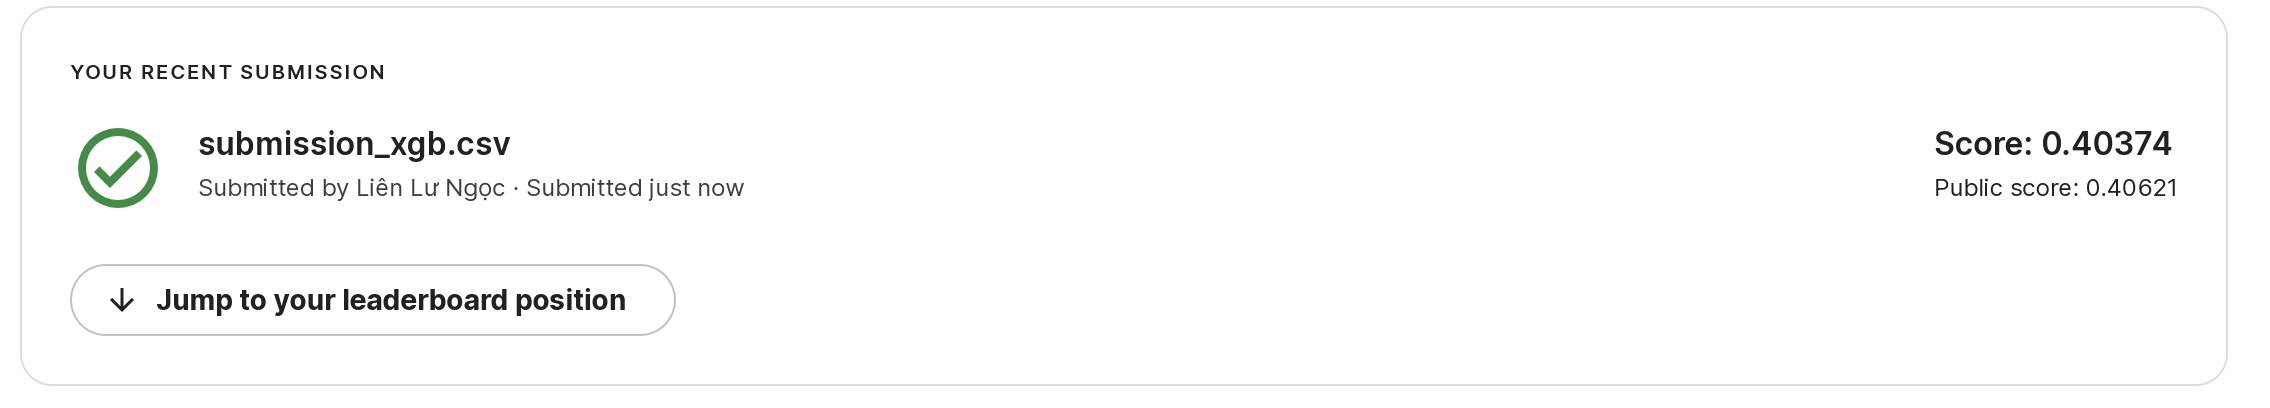

* **Week09**

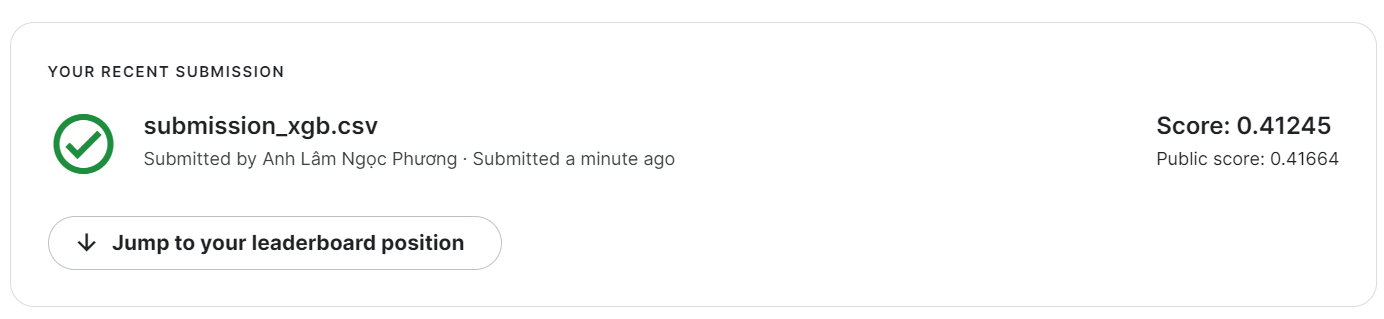

##### Features importance

In [ ]:
feature_importance_dict = model_xgb.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)
feature_importance['importance'] = feature_importance['importance']/ feature_importance['importance'].sum()

feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
10,cnt_hour_pickup_cluster,0.11
8,dropoff_cluster,0.10
5,distance_manhattan,0.09
13,avg_speed_h_pickup_cluster_dropoff_cluster,0.09
4,distance_haversine,0.07
11,avg_speed_h_hour_dropoff_cluster,0.07
7,pickup_cluster,0.07
9,avg_speed_h_hour_pickup_cluster,0.07
6,direction,0.07
12,cnt_hour_dropoff_cluster,0.07


* **Observations**
    * As expected, distance has a significant impact on trip duration. Besides that, the group of location/ area and direction let us know whether the destination will be crowded or not to estimate the time correctly.
    * As we visualised before, the hour and day of the month let us know more about congestion.
    * The count of trip records when grouped by pickup cluster and dropoff cluster is seen not good as expected. It just counts the id having the same pickup and dropoff location without caring about the situation (the hour, the day,…).

### Stacking model 

In [ ]:
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_regression
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import StackingRegressor
# from matplotlib import pyplot

In [ ]:
# # get a stacking ensemble of models
# def get_stacking():
# 	# define the base models
# 	level0 = list()
# 	level0.append(('xgb', xgb.XGBRegressor()))
# 	# level0.append(('random', RandomForestRegressor()))
# 	# level0.append(('extra', ExtraTreesRegressor()))
# 	# level0.append(('cart', DecisionTreeRegressor()))
# 	level0.append(('linear', LinearRegression()))
# 	# define meta learner model
# 	level1 = xgb.XGBRegressor()
# 	# define the stacking ensemble
# 	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# 	return model

In [ ]:
# model = get_stacking()    
# # giving all values to pipeline 
# stack_pipe = Pipeline(steps=[('preprocessor', preprocessor),('stack', model)])

# stack_pipe.fit(X_train, y_train)

# # make predictions on training set
# y_pred_stack = stack_pipe.predict(X_val)

In [ ]:
# # to print the results in good way
# print(f"Validation RMSLE: {mean_squared_error(y_pred_stack, y_val, squared=False)}")

In [ ]:
# y_pre_stack_test = stack_pipe.predict(test)

In [ ]:
# y_pre_stack_test

In [ ]:
# new_df = test.copy()
# new_df['trip_duration'] = np.exp(y_pre_stack_test) - 1
# new_df = new_df[['id', 'trip_duration']]
# new_df.head()

In [ ]:
# new_df.to_csv("submission_stack_xgb_linear.csv", index = False)

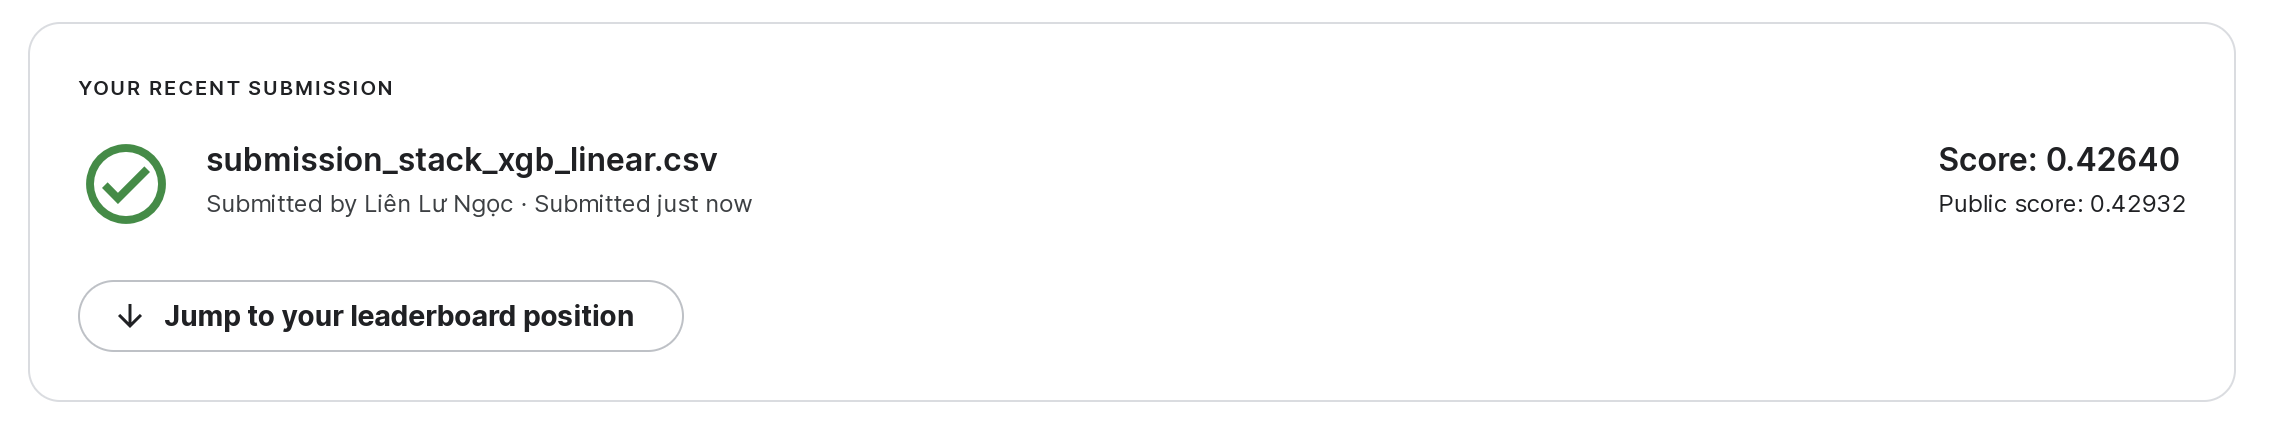

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error

https://www.geeksforgeeks.org/xgboost/

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

https://www.kaggle.com/code/felipefiorini/xgboost-hyper-parameter-tuning 